In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from zipfile import ZipFile
from google.colab import drive
from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import SelectPercentile, SelectFromModel, RFE
from sklearn.decomposition import PCA

In [18]:
# Googleドライブのマウント
drive.mount('/content/drive')

# 作業ディレクトリとパスの設定
BASE_DIR = "/content/drive/My Drive/MachineLearning/feature-engineering"
ZIP_FILE_PATH = f"{BASE_DIR}/data/IoT Network Intrusion Dataset.csv.zip"
EXTRACT_PATH = f"{BASE_DIR}/data"
CSV_FILE_PATH = f"{EXTRACT_PATH}/IoT Network Intrusion Dataset.csv"

# ZIPファイルの解凍
with ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_PATH)

# 読み込むデータ数の設定
num_rows = 10000

# CSVデータの読み込み
data = pd.read_csv(CSV_FILE_PATH, nrows = num_rows)

# 解凍したファイルの削除
os.remove(CSV_FILE_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# データを表示
display(data.head())  # 最初の数行のみ表示
print(f"Data shape: {data.shape}")

,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Timestamp,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,...,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,Cat,Sub_Cat
0,192.168.0.13-192.168.0.16-10000-10101-17,192.168.0.13,10000,192.168.0.16,10101,17,25/07/2019 03:25:53 AM,75,1,1,...,0.0,0.0,0.0,75.0,0.000000,75.0,75.0,Anomaly,Mirai,Mirai-Ackflooding
1,192.168.0.13-222.160.179.132-554-2179-6,222.160.179.132,2179,192.168.0.13,554,6,26/05/2019 10:11:06 PM,5310,1,2,...,0.0,0.0,0.0,2655.0,2261.327486,4254.0,1056.0,Anomaly,DoS,DoS-Synflooding
2,192.168.0.13-192.168.0.16-9020-52727-6,192.168.0.16,52727,192.168.0.13,9020,6,11/07/2019 01:24:48 AM,141,0,3,...,0.0,0.0,0.0,70.5,0.707107,71.0,70.0,Anomaly,Scan,Scan Port OS
3,192.168.0.13-192.168.0.16-9020-52964-6,192.168.0.16,52964,192.168.0.13,9020,6,04/09/2019 03:58:17 AM,151,0,2,...,0.0,0.0,0.0,151.0,0.000000,151.0,151.0,Anomaly,Mirai,Mirai-Hostbruteforceg
4,192.168.0.1-239.255.255.250-36763-1900-17,192.168.0.1,36763,239.255.255.250,1900,17,10/09/2019 01:41:18 AM,153,2,1,...,0.0,0.0,0.0,76.5,0.707107,77.0,76.0,Anomaly,Mirai,Mirai-Hostbruteforceg


Data shape: (10000, 86)


In [20]:
## 不必要な特徴量を分離する

# Anomalyを1, Normalを０に変換し、これをターゲット変数とする
data_Label = data['Label'].map({'Anomaly': 1, 'Normal': 0})
data.drop(columns=['Label'], inplace=True)

# Cat, Sub_Catは攻撃の種類を示す特徴量、Timestampはワンホットエンコーディングの際に特徴量を増やしすぎてしまうので削除
data.drop(columns=['Cat', 'Sub_Cat', 'Timestamp'], inplace=True)

In [21]:
## 数値化されたカテゴリ変数をエンコードする

# エンコーダのインスタンスを作成
encoder = OneHotEncoder(sparse_output=False, categories='auto')

# 整数値のカラムをカテゴリ変数として変換
categorical_columns = [col for col in data.columns if pd.api.types.is_integer_dtype(data[col])]
for col in categorical_columns:
    data[col] = data[col].astype('category')

# カテゴリ変数のみエンコード
encoded_data = encoder.fit_transform(data[categorical_columns])

# エンコードされたデータをデータフレームとして取得
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns))

# エンコードされていない変数と結合
data = pd.concat([data.drop(columns=categorical_columns), encoded_df], axis=1)

In [22]:
# Categorical_columnsを表示
display(Markdown("**Categorical Columns:**"))
display(Markdown(', '.join(categorical_columns)))

# データの表示
display(Markdown("**Data:**"))
display(data.head())  # 最初の数行のみ表示
print(f"Data shape: {data.shape}")

**Categorical Columns:**

Src_Port, Dst_Port, Protocol, Flow_Duration, Tot_Fwd_Pkts, Tot_Bwd_Pkts, Fwd_PSH_Flags, Bwd_PSH_Flags, Fwd_URG_Flags, Bwd_URG_Flags, Fwd_Header_Len, Bwd_Header_Len, FIN_Flag_Cnt, SYN_Flag_Cnt, RST_Flag_Cnt, PSH_Flag_Cnt, ACK_Flag_Cnt, URG_Flag_Cnt, CWE_Flag_Count, ECE_Flag_Cnt, Fwd_Byts/b_Avg, Fwd_Pkts/b_Avg, Fwd_Blk_Rate_Avg, Bwd_Byts/b_Avg, Bwd_Pkts/b_Avg, Bwd_Blk_Rate_Avg, Subflow_Fwd_Pkts, Subflow_Fwd_Byts, Subflow_Bwd_Pkts, Subflow_Bwd_Byts, Init_Fwd_Win_Byts, Init_Bwd_Win_Byts, Fwd_Act_Data_Pkts, Fwd_Seg_Size_Min

**Data:**

,Flow_ID,Src_IP,Dst_IP,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,Fwd_Pkt_Len_Mean,Fwd_Pkt_Len_Std,Bwd_Pkt_Len_Max,...,Fwd_Act_Data_Pkts_51,Fwd_Act_Data_Pkts_58,Fwd_Act_Data_Pkts_60,Fwd_Act_Data_Pkts_74,Fwd_Act_Data_Pkts_82,Fwd_Act_Data_Pkts_83,Fwd_Act_Data_Pkts_94,Fwd_Act_Data_Pkts_102,Fwd_Act_Data_Pkts_131,Fwd_Seg_Size_Min_0
0,192.168.0.13-192.168.0.16-10000-10101-17,192.168.0.13,192.168.0.16,982.0,1430.0,982.0,982.0,982.0,0.000000,1430.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,192.168.0.13-222.160.179.132-554-2179-6,222.160.179.132,192.168.0.13,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,192.168.0.13-192.168.0.16-9020-52727-6,192.168.0.16,192.168.0.13,0.0,2806.0,0.0,0.0,0.0,0.000000,1388.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,192.168.0.13-192.168.0.16-9020-52964-6,192.168.0.16,192.168.0.13,0.0,2776.0,0.0,0.0,0.0,0.000000,1388.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,192.168.0.1-239.255.255.250-36763-1900-17,192.168.0.1,239.255.255.250,886.0,420.0,452.0,434.0,443.0,12.727922,420.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Data shape: (10000, 4932)


In [23]:
# object型のカラムを取得
object_columns = data.select_dtypes(include=['object']).columns

# object型のカラム名を表示
print("Object type columns:")
for col in object_columns:
    print(col)

# object型を変換するone-hot-encodingを行う
data = pd.get_dummies(data)

Object type columns:
Flow_ID
Src_IP
Dst_IP


In [24]:
# データの表示
display(Markdown("**Data:**"))
display(data.head())  # 最初の数行のみ表示
print(f"Data shape: {data.shape}")

**Data:**

,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,Fwd_Pkt_Len_Mean,Fwd_Pkt_Len_Std,Bwd_Pkt_Len_Max,Bwd_Pkt_Len_Min,Bwd_Pkt_Len_Mean,Bwd_Pkt_Len_Std,...,Dst_IP_54.235.254.1,Dst_IP_54.243.36.160,Dst_IP_54.243.56.189,Dst_IP_58.225.75.82,Dst_IP_58.225.75.83,Dst_IP_58.229.187.11,Dst_IP_61.213.189.211,Dst_IP_64.233.189.101,Dst_IP_74.125.96.138,Dst_IP_96.16.99.81
0,982.0,1430.0,982.0,982.0,982.0,0.000000,1430.0,1430.0,1430.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,0.0,2806.0,0.0,0.0,0.0,0.000000,1388.0,30.0,935.333333,784.041666,...,0,0,0,0,0,0,0,0,0,0
3,0.0,2776.0,0.0,0.0,0.0,0.000000,1388.0,1388.0,1388.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,886.0,420.0,452.0,434.0,443.0,12.727922,420.0,420.0,420.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


Data shape: (10000, 8085)


In [25]:
# ターゲット変数の設定
X = data
y = data_Label

# データをトレーニングセットとテストセットに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 無限大の値をNaNに置き換える
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# NaNの値を各カラムの平均で埋める
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_train.mean(), inplace=True)  # 注意: テストデータのNaNはトレーニングデータの平均で埋める

# 特徴量のスケーリング
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # transformのみ適用するように注意

# numpy形式のデータをpandas DataFrameに変換
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

LogisticRegression Accuracy: 99.73%
LogisticRegression Execution Time: 9.33 seconds
Confusion Matrix:
[[ 188    8]
 [   0 2804]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       196
           1       1.00      1.00      1.00      2804

    accuracy                           1.00      3000
   macro avg       1.00      0.98      0.99      3000
weighted avg       1.00      1.00      1.00      3000

--------------------------------------------------------------------------------
DecisionTreeClassifier Accuracy: 99.83%
DecisionTreeClassifier Execution Time: 3.61 seconds
Confusion Matrix:
[[ 191    5]
 [   0 2804]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       196
           1       1.00      1.00      1.00      2804

    accuracy                           1.00      3000
   macro avg       1.00      0.99      0.99      3000
weighted

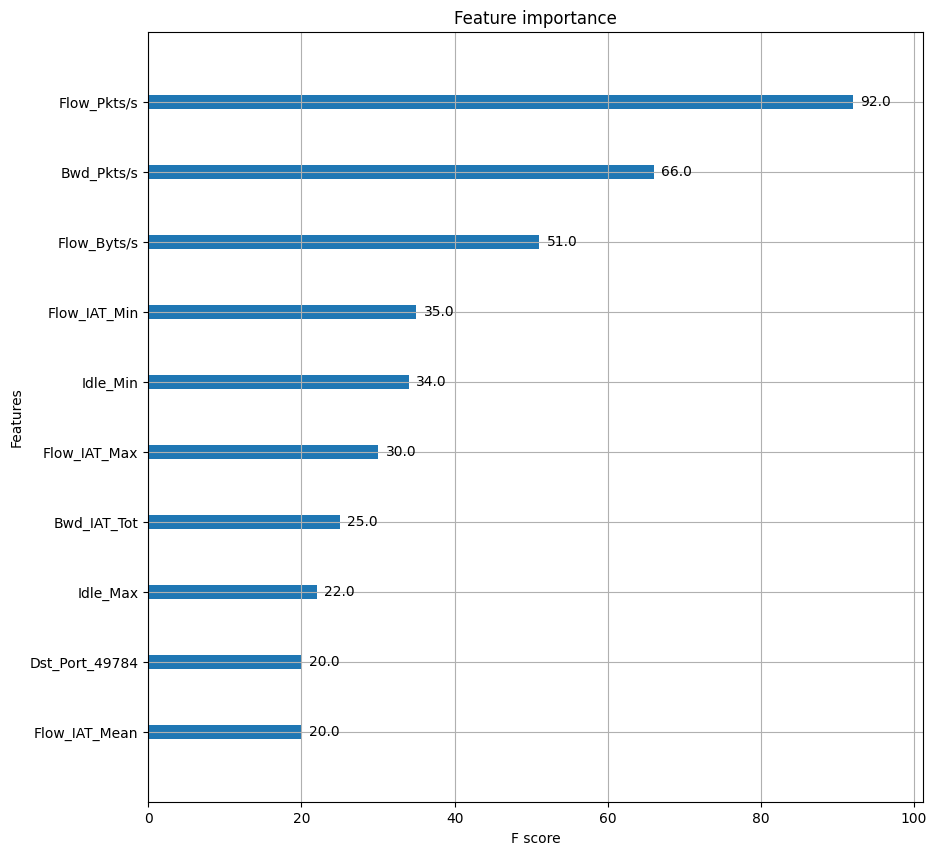

--------------------------------------------------------------------------------


In [27]:
import time
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
import xgboost as xgb
import matplotlib.pyplot as plt

# 学習と評価を行う
def train_and_evaluate(clf, X_train, y_train, X_test, y_test):
    start_time = time.time()  # 学習開始時間を取得

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    end_time = time.time()  # 学習終了時間を取得
    elapsed_time = end_time - start_time  # 実行時間を計算

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{clf.__class__.__name__} Accuracy: {accuracy*100:.2f}%")

    # Execution Time
    print(f"{clf.__class__.__name__} Execution Time: {elapsed_time:.2f} seconds")

    # Confusion Matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Classification Report (Precision, Recall, F1-Score...)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Feature Importance (for XGBClassifier only)
    if isinstance(clf, xgb.XGBClassifier):
        fig, ax = plt.subplots(figsize=(10, 10))
        xgb.plot_importance(clf, ax=ax, importance_type='weight', max_num_features=10)
        plt.show()

    print("-"*80)

models = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    xgb.XGBClassifier(n_estimators=100, max_depth=6, n_jobs=-1)   # 実行に時間がかかるため、ハイパーパラメータを設定
]

for model in models:
    train_and_evaluate(model, X_train, y_train, X_test, y_test)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  49   52   58 ... 8067 8069 8083] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Selected features for Univariate Feature Selection:
['TotLen_Fwd_Pkts', 'TotLen_Bwd_Pkts', 'Fwd_Pkt_Len_Max', 'Fwd_Pkt_Len_Min', 'Fwd_Pkt_Len_Mean', 'Fwd_Pkt_Len_Std', 'Bwd_Pkt_Len_Max', 'Bwd_Pkt_Len_Min', 'Bwd_Pkt_Len_Mean', 'Bwd_Pkt_Len_Std', 'Flow_Byts/s', 'Flow_Pkts/s', 'Flow_IAT_Mean', 'Flow_IAT_Std', 'Flow_IAT_Max', 'Flow_IAT_Min', 'Fwd_IAT_Std', 'Fwd_IAT_Max', 'Bwd_IAT_Tot', 'Bwd_IAT_Mean', 'Bwd_IAT_Std', 'Bwd_IAT_Max', 'Bwd_IAT_Min', 'Fwd_Pkts/s', 'Bwd_Pkts/s', 'Pkt_Len_Min', 'Pkt_Len_Max', 'Pkt_Len_Mean', 'Pkt_Len_Std', 'Pkt_Len_Var', 'Down/Up_Ratio', 'Pkt_Size_Avg', 'Fwd_Seg_Size_Avg', 'Bwd_Seg_Size_Avg', 'Active_Mean', 'Active_Std', 'Active_Max', 'Active_Min', 'Idle_Mean', 'Idle_Std', 'Idle_Max', 'Idle_Min', 'Src_Port_0', 'Src_Port_80', 'Src_Port_137', 'Src_Port_443', 'Src_Port_1015', 'Src_Port_1056', 'Src_Port_1067', 'Src_Port_1227', 'Src_Port_1237', 'Src_Port_1289', 'Src_Port_1312', 'Src_Port_1328', 'Src_Port_1338', 'Src_Port_1376', 'Src_Port_1452', 'Src_Port_1538', 'Src_P

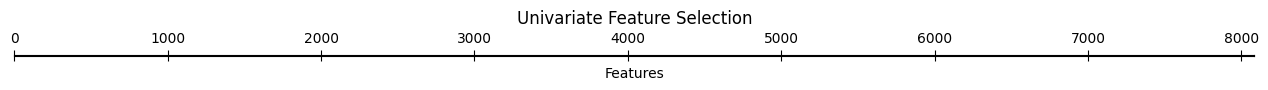

LogisticRegression Accuracy: 99.73%
LogisticRegression Execution Time: 3.04 seconds
Confusion Matrix:
[[ 188    8]
 [   0 2804]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       196
           1       1.00      1.00      1.00      2804

    accuracy                           1.00      3000
   macro avg       1.00      0.98      0.99      3000
weighted avg       1.00      1.00      1.00      3000

--------------------------------------------------------------------------------
Selected features for Model-based Feature Selection:
['TotLen_Fwd_Pkts', 'TotLen_Bwd_Pkts', 'Fwd_Pkt_Len_Max', 'Fwd_Pkt_Len_Min', 'Fwd_Pkt_Len_Mean', 'Fwd_Pkt_Len_Std', 'Bwd_Pkt_Len_Max', 'Bwd_Pkt_Len_Min', 'Bwd_Pkt_Len_Mean', 'Bwd_Pkt_Len_Std', 'Flow_Byts/s', 'Flow_Pkts/s', 'Flow_IAT_Mean', 'Flow_IAT_Std', 'Flow_IAT_Max', 'Flow_IAT_Min', 'Fwd_IAT_Tot', 'Fwd_IAT_Mean', 'Fwd_IAT_Std', 'Fwd_IAT_Max', 'Fwd_IAT_Min', 'Bwd_IAT_Tot', 'Bwd_IAT

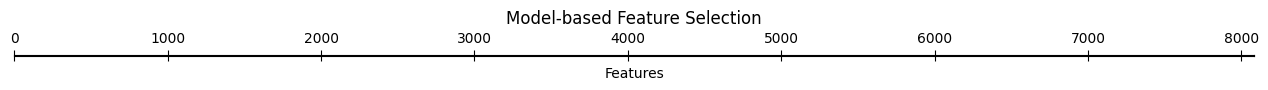

LogisticRegression Accuracy: 99.73%
LogisticRegression Execution Time: 4.89 seconds
Confusion Matrix:
[[ 188    8]
 [   0 2804]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       196
           1       1.00      1.00      1.00      2804

    accuracy                           1.00      3000
   macro avg       1.00      0.98      0.99      3000
weighted avg       1.00      1.00      1.00      3000

--------------------------------------------------------------------------------


In [28]:
# 特徴量選択
selectors = [
    ("Univariate Feature Selection", SelectPercentile(percentile=50)),
    ("Model-based Feature Selection", SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold="median"))
]

for name, selector in selectors:
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    # 選ばれた特徴量を選択
    mask = selector.get_support()

    # 選ばれた特徴量の名前を表示
    selected_features = [feature for feature, bool_val in zip(X_train.columns, mask) if bool_val]
    print(f"Selected features for {name}:")
    print(selected_features)
    print('-'*80)

    plt.matshow(mask.reshape(1, -1), cmap='gray_r')
    plt.title(name)
    plt.xlabel("Features")
    plt.yticks(())
    plt.show()

    train_and_evaluate(LogisticRegression(max_iter=1000), X_train_selected, y_train, X_test_selected, y_test)

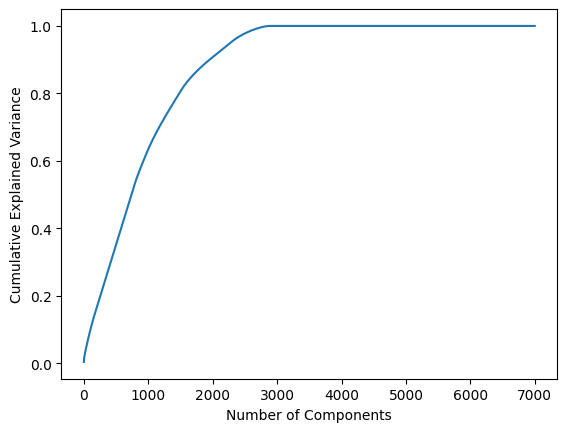

In [29]:
# PCAのインスタンスを作成
pca = PCA()

# トレーニングデータにPCAをフィット
X_train_pca = pca.fit_transform(X_train)

# テストデータにPCAを適用
X_test_pca = pca.transform(X_test)

# 累積寄与率のプロット
import matplotlib.pyplot as plt

cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [30]:
# 上のプロットから、n_components=2500とし、もう一度PCAを実行
pca = PCA(n_components=2500)

# トレーニングデータにPCAをフィット
X_train_pca = pca.fit_transform(X_train)

# テストデータにPCAを適用
X_test_pca = pca.transform(X_test)

LogisticRegression Accuracy: 99.77%
LogisticRegression Execution Time: 1.51 seconds
Confusion Matrix:
[[ 189    7]
 [   0 2804]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       196
           1       1.00      1.00      1.00      2804

    accuracy                           1.00      3000
   macro avg       1.00      0.98      0.99      3000
weighted avg       1.00      1.00      1.00      3000

--------------------------------------------------------------------------------
DecisionTreeClassifier Accuracy: 98.37%
DecisionTreeClassifier Execution Time: 48.19 seconds
Confusion Matrix:
[[ 161   35]
 [  14 2790]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.82      0.87       196
           1       0.99      1.00      0.99      2804

    accuracy                           0.98      3000
   macro avg       0.95      0.91      0.93      3000
weighte

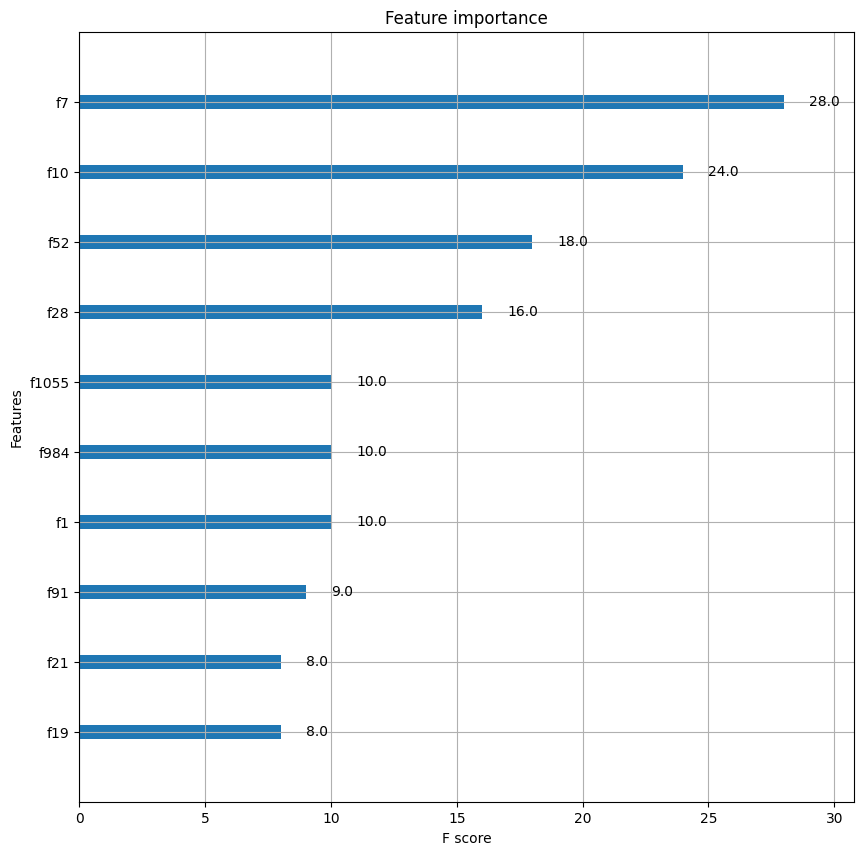

--------------------------------------------------------------------------------


In [31]:
# 再度学習と評価を行う
# 実行する
models = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    xgb.XGBClassifier(n_estimators=100, max_depth=6, n_jobs=-1)
]

for model in models:
    train_and_evaluate(model, X_train_pca, y_train, X_test_pca, y_test)